In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error

In [ ]:
data = pd.read_csv('/content/co2_mm_mlo.csv', delimiter=';')

In [ ]:
data.isnull().sum()

year            0
month           0
decimal_date    0
average         0
interpolated    0
dtype: int64

In [ ]:
data

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,-99.99,317.10
4,1958,7,1958.542,315.86,315.86
...,...,...,...,...,...
701,2016,8,2016.625,402.25,402.25
702,2016,9,2016.708,401.03,401.03
703,2016,10,2016.792,401.57,401.57
704,2016,11,2016.875,403.53,403.53


In [ ]:
#препроцессинг данных
data['date'] = pd.to_datetime(data[['year', 'month']].assign(day=1))
data.sort_values(by='date', inplace=True)
data = data[['date', 'interpolated']]

scaler = MinMaxScaler(feature_range=(0, 1))
data['scaled_interpolated'] = scaler.fit_transform(data[['interpolated']])

<ipython-input-40-015e4c8ed270>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['scaled_interpolated'] = scaler.fit_transform(data[['interpolated']])


In [ ]:
data

,date,interpolated,scaled_interpolated
0,1958-03-01,315.71,0.032092
1,1958-04-01,317.45,0.050400
2,1958-05-01,317.50,0.050926
3,1958-06-01,317.10,0.046717
4,1958-07-01,315.86,0.033670
...,...,...,...
701,2016-08-01,402.25,0.942656
702,2016-09-01,401.03,0.929819
703,2016-10-01,401.57,0.935501
704,2016-11-01,403.53,0.956124


In [ ]:
# Преобразование данных
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 12  # берем 12 месяцев

dataset = data['scaled_interpolated'].values
dataset = dataset.reshape(-1, 1)

train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], look_back, 1))
X_test = np.reshape(X_test, (X_test.shape[0], look_back, 1))


In [ ]:
# Создание модели
model = Sequential()
model.add(LSTM(150, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.2))
model.add(LSTM(150))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Обучение модели
model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/100
18/18 [==============================] - 4s 66ms/step - loss: 0.0223 - val_loss: 7.7196e-04
Epoch 2/100
18/18 [==============================] - 1s 30ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 3/100
18/18 [==============================] - 1s 31ms/step - loss: 0.0016 - val_loss: 7.6795e-04
Epoch 4/100
18/18 [==============================] - 1s 29ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 5/100
18/18 [==============================] - 1s 31ms/step - loss: 0.0012 - val_loss: 8.4914e-04
Epoch 6/100
18/18 [==============================] - 1s 31ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 7/100
18/18 [==============================] - 1s 30ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 8/100
18/18 [==============================] - 1s 31ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 9/100
18/18 [==============================] - 1s 32ms/step - loss: 0.0013 - val_loss: 8.3587e-04
Epoch 10/100
18/18 [==============================] - 1s 31ms/step - loss: 0.0011 - 

In [ ]:
# Прогноз
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
Y_train = scaler.inverse_transform([Y_train])
Y_test = scaler.inverse_transform([Y_test])

5/5 [==============================] - 0s 8ms/step


In [ ]:
# Оценка модели
train_score = math.sqrt(mean_squared_error(Y_train[0], train_predict[:, 0]))
test_score = math.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
print(f'Train Score: {train_score} RMSE')
print(f'Test Score: {test_score} RMSE')

Train Score: 0.7706646806871933 RMSE
Test Score: 1.5302624879495594 RMSE


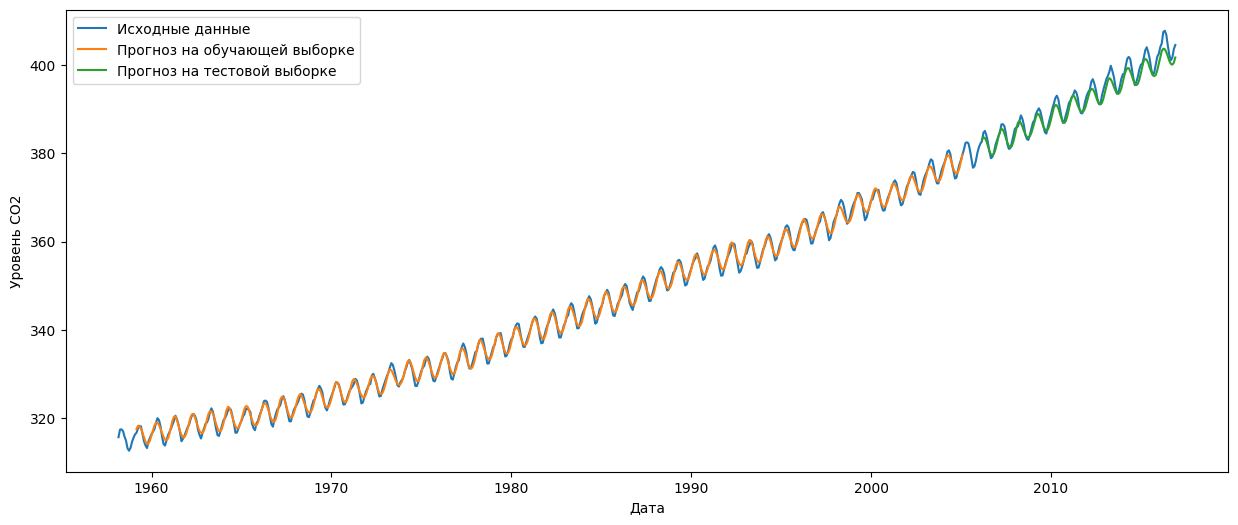

In [ ]:
# Смещение и графики
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict) + look_back, :] = train_predict

test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (look_back * 2):len(dataset), :] = test_predict

plt.figure(figsize=(15, 6))
plt.plot(data['date'], scaler.inverse_transform(dataset), label='Исходные данные')
plt.plot(data['date'], train_predict_plot, label='Прогноз на обучающей выборке')
plt.plot(data['date'], test_predict_plot, label='Прогноз на тестовой выборке')
plt.xlabel('Дата')
plt.ylabel('Уровень CO2')
plt.legend()
plt.show()